In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# How to create a Tsybakov Noise Dataset which exponent alpha, s.t.
# We can easily create a model that satisfies some hypotheses.

# So we need for all x in X, that \Delta C_(l2, H)(h,x) inequality holds.

# Ok, lets note that C_(l, H)(h,x) = E[R_l(h,x)] - 0, where x is random
# Because for linear models the infimum will always be 0 (and if noise is non-zero
# The infimum is achieved).

# Ok, now how hard is it to find something that obeys \Delta C_l1 \leq \Gamma(\Delta C_l2)

# The part in the Tsybakov noise assumption saying M_{l_{0,1}} = 0 is just saying that we've
# picked an appropriate class of models for this problem.

# Ok, lets say we use logistic loss, which is \Phi(u) = \log(1 + \exp(-u)), and since we can use
# margin-based loss functions like l(h,x,y) = \Phi(yh(x)), and h(x) would be like dot product
# between weights of model and datapoints

# how do we assure that \Delta C_{l_bin} \leq \Gamma ...

# Maybe just start by finding the \Gamma that works...

In [3]:
eta = lambda x: 1/(1+np.exp(-x))
inverse_eta = lambda x: np.log(x/(1-x))

loss = lambda x: np.log(1 + np.exp(-x))
margin_loss = lambda h_x, y: loss(y * h_x)

C_surr = lambda h, x: eta(x) * margin_loss(h(x), 1) + (1-eta(x)) * margin_loss(h(x), -1)
C_surr_star = lambda x: -1*(eta(x) * np.log(eta(x)) + (1-eta(x))*np.log(1-eta(x))) # At least for the log_e version of the loss
C_target = lambda h, x: eta(x) * (h(x) < 0) + (1-eta(x)) * (h(x) > 0) # Maybe it should be h(x) < 0 and h(x) > 0 respectively?
C_target_star = lambda x: min(eta(x), 1-eta(x))

In [8]:
def get_errors(X, Y):
    from sklearn.linear_model import SGDClassifier
    classifier = SGDClassifier(
        loss='log_loss',
        max_iter=1,          # Each call to partial_fit makes exactly one pass over the chunk
        tol=None,
        random_state=42,
        shuffle=True,        # Good idea to shuffle data between epochs if you run this multiple times
        learning_rate='constant',
        eta0=0.1
    )
    
    h = lambda x_input: classifier.coef_[0][0] * x_input + classifier.intercept_[0]

    all_classes = np.unique(Y)
    coef_history = []
    intercept_history = []

    delta_C_surr = []
    delta_C_target = []

    chunk_size = 5
    num_chunks = len(X) // chunk_size

    # Iterate over batches of 100 samples
    for i in range(min(num_chunks, 1000)):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        X_chunk = X[start_idx:end_idx]
        y_chunk = Y[start_idx:end_idx]

        if i == 0:
            # Provide all possible classes in the first call
            classifier.partial_fit(X_chunk, y_chunk, classes=all_classes)
        else:
            classifier.partial_fit(X_chunk, y_chunk)
        
        # Calculate costs using the current state of the hypothesis 'h'
        # Ensure X is correctly shaped when passed to the lambda function h

        temp_surr = [C_surr(h, x[0]) - C_surr_star(x[0]) for x in X]
        temp_target = [C_target(h, x[0]) - C_target_star(x[0]) for x in X]
        
        # Store the results (e.g., store the mean of these deltas)
        delta_C_surr.append((temp_surr))
        delta_C_target.append((temp_target))

        # Store and print the model parameters after this batch update
        coef_history.append(classifier.coef_.copy())
        intercept_history.append(classifier.intercept_.copy())
        # print(f"Batch {i+1}: Coef: {classifier.coef_}, Intercept: {classifier.intercept_}")
        # print(h(0.5))  # Example of using h
    return delta_C_surr, delta_C_target

def plot_sample_errors(delta_C_surr, delta_C_target, ax, alpha):
    cmap = plt.cm.viridis  # or 'plasma', 'inferno', etc.
    num_colors = len(delta_C_surr)

    for i in range(num_colors):
        # print(i, min(delta_C_surr[i]))
        arr_surr = [np.log(x + 1e-15) for x in delta_C_surr[i]]
        arr_target = [np.log(x + 1e-15) for x in delta_C_target[i]]

        color = cmap(alpha)  # smoothly increasing color

        idx = np.random.choice(len(arr_surr), size=min(100, len(arr_surr)), replace=False)

        arr_surr_sampled = [arr_surr[j] for j in idx]
        arr_target_sampled = [arr_target[j] for j in idx]

        ax.scatter(arr_surr_sampled, [0.5 * a for a in arr_surr_sampled], color='red')
        ax.scatter(arr_surr_sampled, arr_target_sampled, alpha=0.2, color=color, label=str(i))


def plot_mean_errors(delta_C_surr, delta_C_target, ax, alpha):
    cmap = plt.cm.viridis  # or 'plasma', 'inferno', etc.
    num_colors = len(delta_C_surr)

    for i in range(num_colors):
        mean_surr = sum(delta_C_surr[i])/(len(delta_C_surr[i]))
        mean_target = sum(delta_C_target[i])/(len(delta_C_target[i]))

        # print(mean_surr)

        color = cmap(alpha)  # smoothly increasing color

        ax.scatter(np.log(mean_surr + 1e-15), 1/(2-alpha)*np.log(mean_surr + 1e-15), color='red') # True function, Upper bound, the colored dots should be below this
        ax.scatter(np.log(mean_surr + 1e-15), np.log(mean_target + 1e-15), alpha=0.2, color=color)
        # Shows that there is a lot of fluctuation in mean_target loss, even though the surrogate loss is decreasing
        # pretty steadily

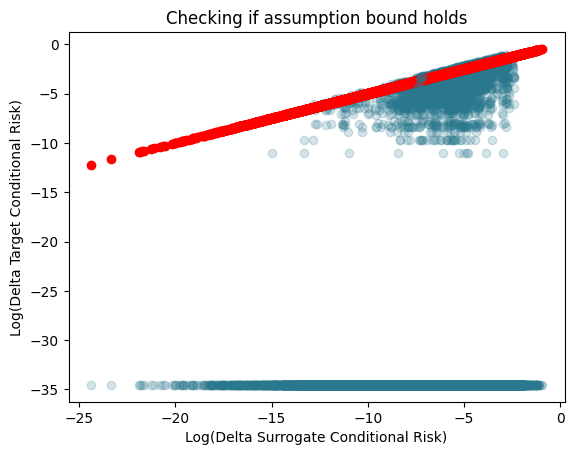

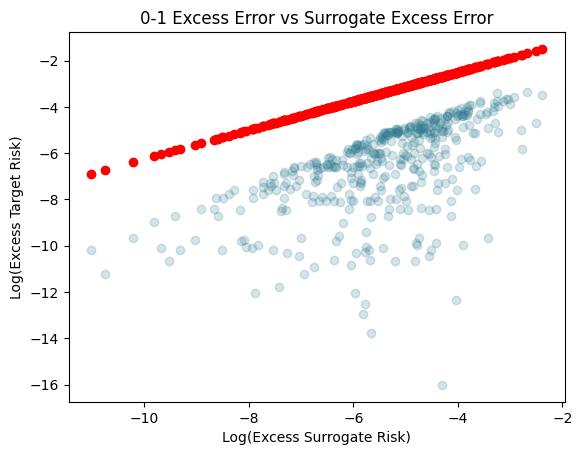

In [15]:
# If P(|n(x)-0.5| \leq t) = t^\beta * C, and |n(x)-0.5|

# Maximally Tsybakov

# Lets try to refactor this

fig1, sample_ax = plt.subplots(1, 1)
fig2, mean_ax  = plt.subplots(1, 1)
sample_ax.set_title("Checking if assumption bound holds")
mean_ax.set_title("0-1 Excess Error vs Surrogate Excess Error")

mean_ax.set_xlabel("Log(Excess Surrogate Risk)")
mean_ax.set_ylabel("Log(Excess Target Risk)")

sample_ax.set_xlabel("Log(Delta Surrogate Conditional Risk)")
sample_ax.set_ylabel("Log(Delta Target Conditional Risk)")


for alpha in [0.4]:
    beta = alpha/(1-alpha)

    signal = [((x) ** (1/beta))/2 for x in np.random.rand(1000)] + [0.01, 0.49]
    arr = []

    for t in signal:
        arr.extend([0.5 + t, 0.5 - t])

    X = [inverse_eta(x) for x in arr]
    Y = [np.random.binomial(n=1, p=eta(x))*2 - 1 for x in X]

    random_indices = np.random.permutation(range(len(X)))
    X = np.array(X)
    Y = np.array(Y)

    X = X[random_indices]
    Y = Y[random_indices]

    if X.ndim == 1:
        X = X.reshape(-1, 1)


    delta_C_surr, delta_C_target = get_errors(X, Y)

    plot_sample_errors(delta_C_surr, delta_C_target, sample_ax, alpha)
    plot_mean_errors(delta_C_surr, delta_C_target, mean_ax, alpha)

fig1.savefig("LR_assump.png")
fig2.savefig("LR_error.png")
plt.show()

0.09233930292839021
0.06348939881506664
0.05551981920646752
0.06307877622518263
0.0597640883199349
0.0348889028034865
0.041669404128804655
0.02692088313780212
0.036796425032834014
0.03389549794953209
0.023993492047214772
0.012785594822269453
0.01778131198601017
0.00644257606235351
0.02356076592016446
0.019678057607761215
0.013811428331656536
0.015821823758155325
0.013054705614074255
0.014168247555108442
0.023723506496079405
0.020936660068608108
0.019004312397318944
0.020120322554965823
0.018695339072749298
0.011000408533192424
0.015173867506789002
0.0063746604614379546
0.008137536797911422
0.006153168156561857
0.007096673309532652
0.01395315846881945
0.004678094703259845
0.0008611741495135161
0.0011615365823868385
0.00351361421632208
0.00774167571739783
0.001553452278158152
0.000184174750495226
9.13828241291437e-05
0.00011128037832981666
0.0018411416070989845
2.2785123543836375e-05
0.001110231828876769
0.004565297800471392
0.0005558719724729394
0.0017444578447876906
0.00276811472097264

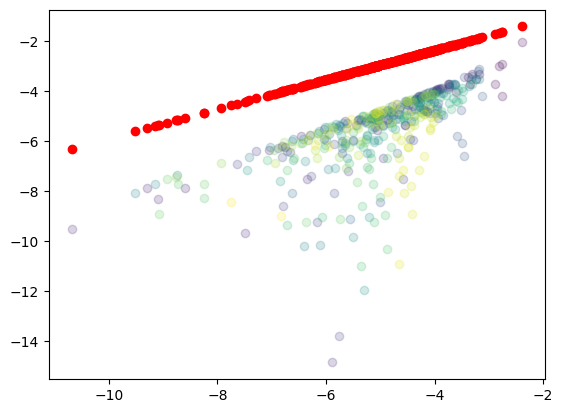

In [6]:
cmap = plt.cm.viridis  # or 'plasma', 'inferno', etc.
num_colors = len(delta_C_surr)

for i in range(num_colors):
    mean_surr = sum(delta_C_surr[i])/(len(delta_C_surr[i]))
    mean_target = sum(delta_C_target[i])/(len(delta_C_target[i]))

    print(mean_surr)

    color = cmap(i / num_colors)  # smoothly increasing color

    plt.scatter(np.log(mean_surr), 1/(2-alpha)*np.log(mean_surr), color='red') # True function, Upper bound, the colored dots should be below this
    plt.scatter(np.log(mean_surr), np.log(mean_target), alpha=0.2, color=color)
    # Shows that there is a lot of fluctuation in mean_target loss, even though the surrogate loss is decreasing
    # pretty steadily

plt.show()

NameError: name 'classifier' is not defined

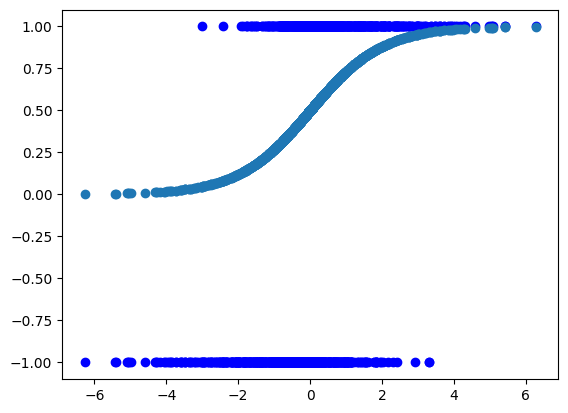

In [7]:
plt.scatter(X, Y, color='blue')
plt.scatter(X, [eta(x) for x in X])
plt.scatter(X, classifier.predict_proba(X)[:,1], color='red')
plt.show()

In [ ]:
# Can't be uniform noise, Gaussian noise would have some alpha...

X1_plus = np.random.normal(size=(100)) + 0.5
X1_minus = np.random.normal(size=(100)) - 0.5

# This won't really satisfy the Tsybakov assumptions
# Maybe we have to manually construct it with a power law... around 0.

# I don't think any overlapping Gaussians satisfy Tsybakov noise.... Uniform distributions definitely don't

# What is the purest way to create such a model? Maybe the training set is exactly the test set.
# How, with significance, can we determine a dataset is Tsybakov...

# Algorithmic, find a way to make \Gamma the smallest possible.

In [ ]:
# Ok, we have a decent demonstration, and I'm pretty sure all the code is right, modulo some constants that shouldn't matter 
# asmyptotically. Next thing you could work on is developing a universal growth rate for proper losses
# Margin-based losses only depend on scores, but more general proper losses are a superset of margin-based losses
# and they only depend on the probabilities.

# Also think about how to verify that a dataset has Tsybakov noise level alpha, with h.p.